In [1]:
#!unzip drive/MyDrive/intel.zip

This is image date of Natural Scenes around the world. This Data contains around 25k images of size 150x150 distributed under 6 categories.

'buildings' -> 0
'forest' -> 1
'glacier' -> 2
'mountain' -> 3
'sea' -> 4
'street' -> 5

There are 14k images in Train, 3k in Test, and 7k in Prediction.

**Goal: The goal of this project is to build a Neural Network to classify these images more accurately.**

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from PIL import Image
import glob
from pathlib import Path
import cv2
import matplotlib.image as mpimg
import os

In [3]:
train_dir = 'intel/seg_train/seg_train/'
test_dir = 'intel/seg_test/seg_test/'
pred_dir = 'intel/seg_pred/seg_pred/'

image_train = len(list(Path(train_dir).glob('*/*.jpg')))
image_test = len(list(Path(test_dir).glob('*/*.jpg')))
image_pred = len(list(Path(pred_dir).glob('*.jpg')))

print("Train images: ", image_train)
print("Test images: ", image_test)
print("Pred images: ", image_pred)

Train images:  14034
Test images:  3000
Pred images:  7301


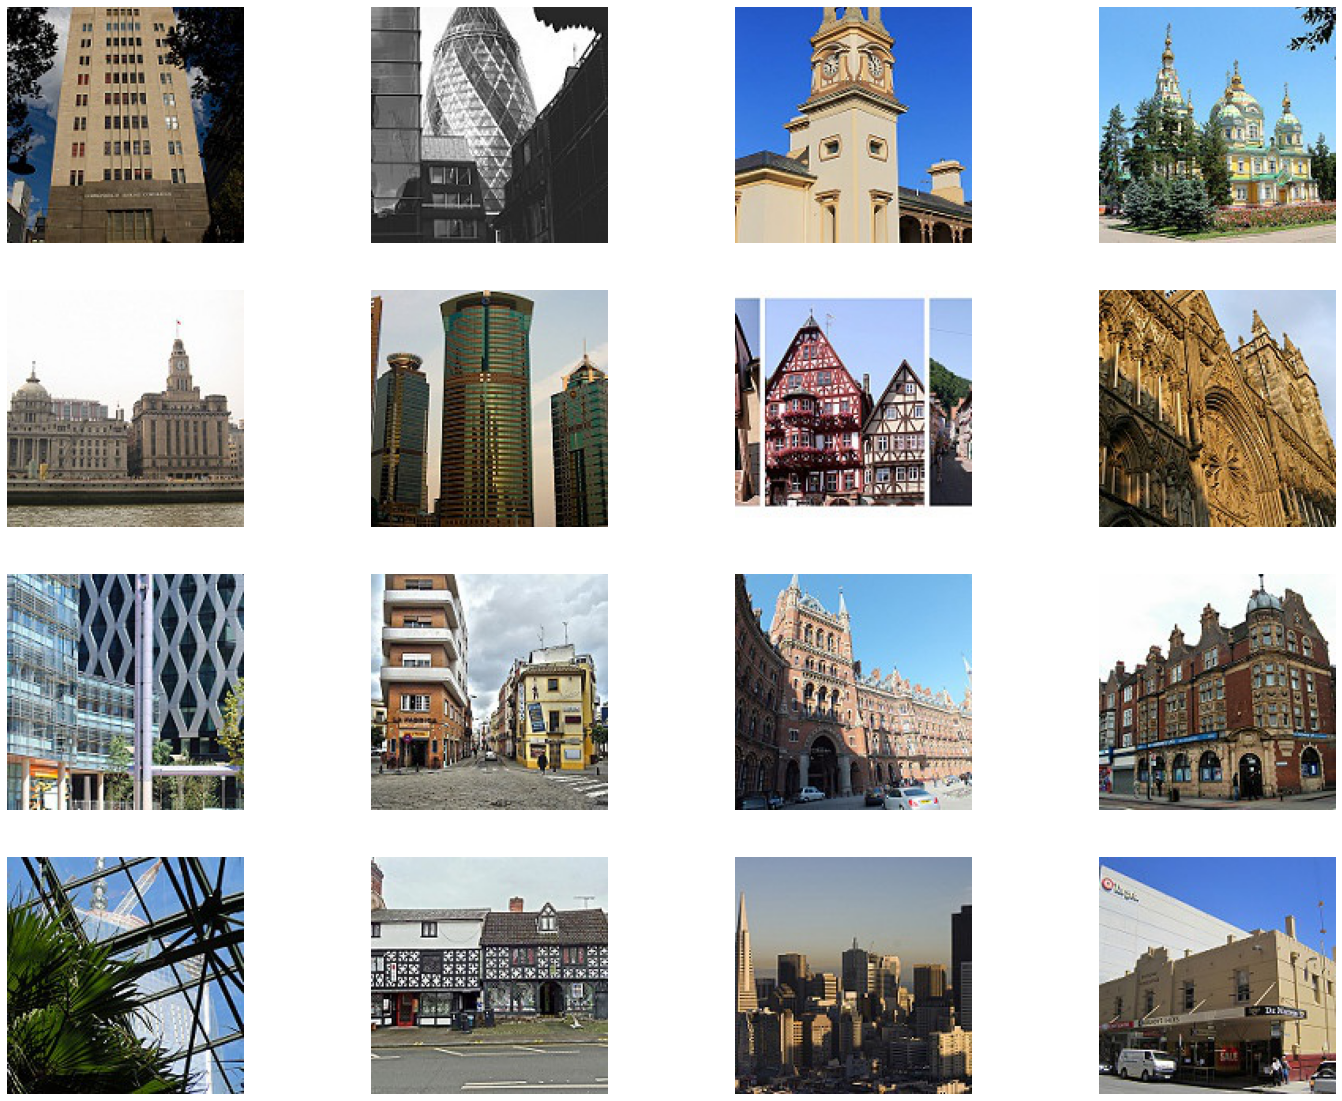

In [4]:
plt.figure(figsize=(25,20))
img_buildings =[]
dir = 'intel/seg_train/seg_train/buildings/'
for img in Path(train_dir).glob('buildings/*.jpg'):
    img_buildings.append(mpimg.imread(img))


for i in range (16):
    rand = np.random.randint(0, len(img_buildings))
    plt.subplot(4, 4, i+1)
    plt.imshow(img_buildings[rand])
    plt.axis("off")

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,                                            
                                                 seed=10, 
                                                 image_size = (150, 150),
                                                 batch_size = 32)

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                 seed=10, 
                                                 image_size = (150, 150),
                                                 batch_size = 32)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


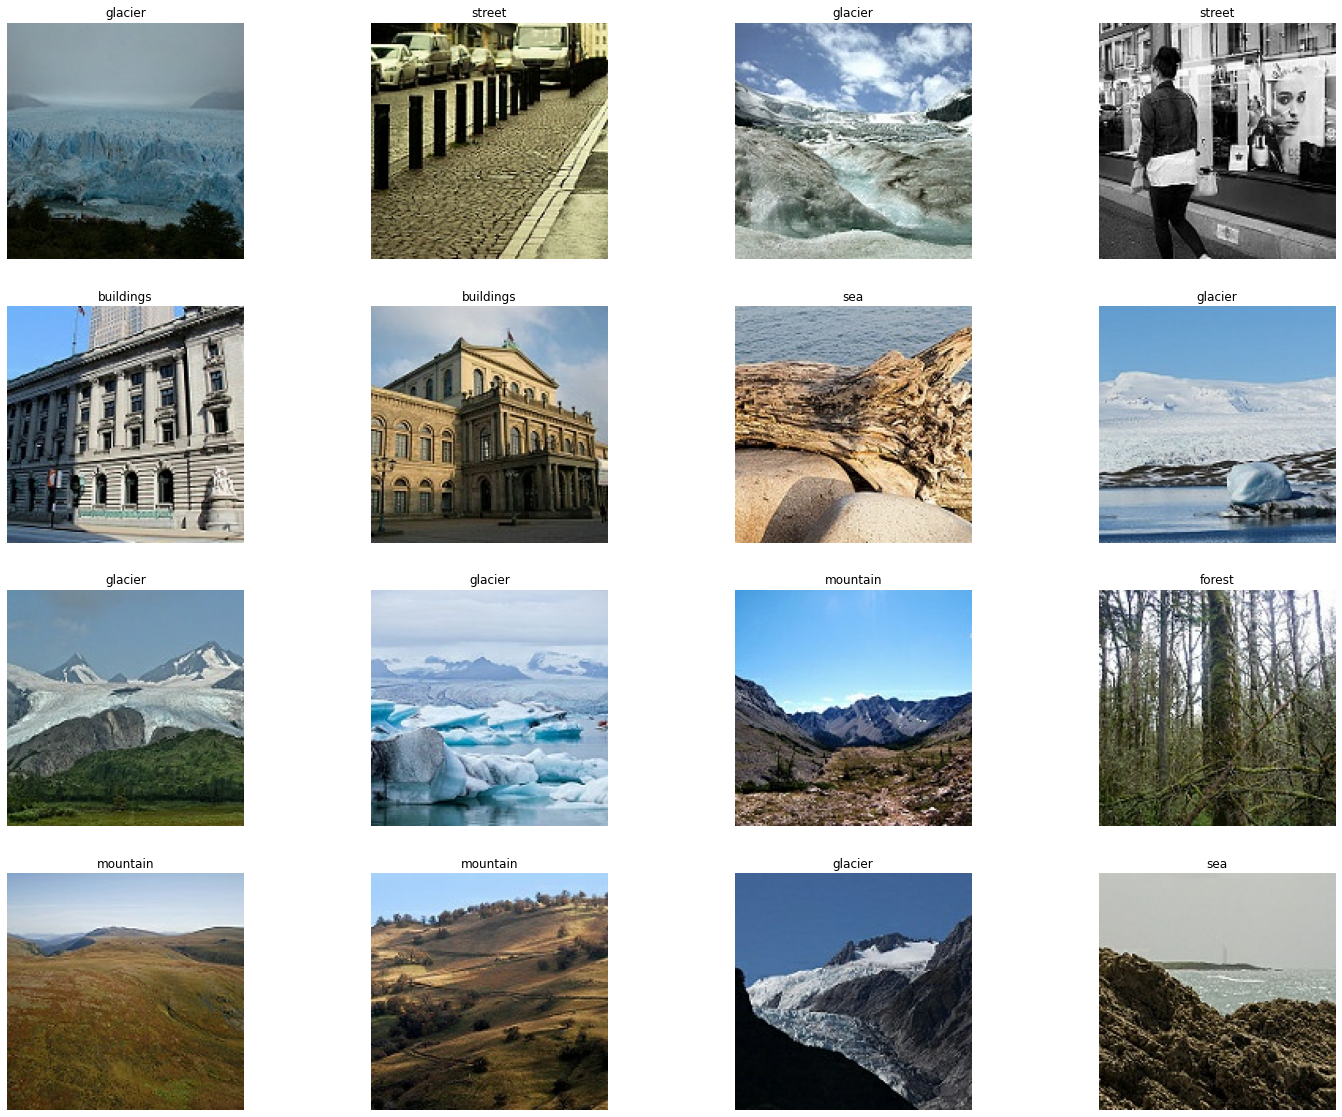

In [7]:
plt.figure(figsize=(25, 20))

for img, label in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal", input_shape=(150, 150,3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

In [10]:
model = tf.keras.Sequential()
model.add(data_augmentation)
model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(6))

In [11]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [12]:
model.compile(optimizer=optimizer, loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [13]:
model.build(input_shape=(None, 150, 150, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)       

In [14]:
history = model.fit(train_ds, 
                    validation_data = test_ds,
                    epochs = 100,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    verbose = 1)

Epoch 1/100
439/439 [==============================] - 331s 732ms/step - loss: 1.2795 - accuracy: 0.5733 - val_loss: 2.3176 - val_accuracy: 0.3403
Epoch 2/100
439/439 [==============================] - 329s 750ms/step - loss: 0.9210 - accuracy: 0.6736 - val_loss: 1.4661 - val_accuracy: 0.5787
Epoch 3/100
439/439 [==============================] - 329s 749ms/step - loss: 0.7885 - accuracy: 0.7214 - val_loss: 1.1257 - val_accuracy: 0.6477
Epoch 4/100
439/439 [==============================] - 328s 747ms/step - loss: 0.7179 - accuracy: 0.7480 - val_loss: 0.7421 - val_accuracy: 0.7343
Epoch 5/100
439/439 [==============================] - 337s 768ms/step - loss: 0.6755 - accuracy: 0.7580 - val_loss: 1.1314 - val_accuracy: 0.6687
Epoch 6/100
439/439 [==============================] - 327s 744ms/step - loss: 0.6210 - accuracy: 0.7820 - val_loss: 0.6728 - val_accuracy: 0.7677
Epoch 7/100
439/439 [==============================] - 338s 769ms/step - loss: 0.5876 - accuracy: 0.7912 - val_loss: 0

In [15]:
#model.save('intel/model')
#model = tf.keras.models.load_model('intel/model')

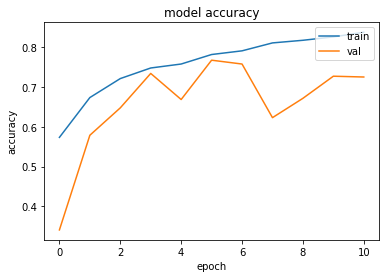

In [16]:
# Plot model accuracy 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

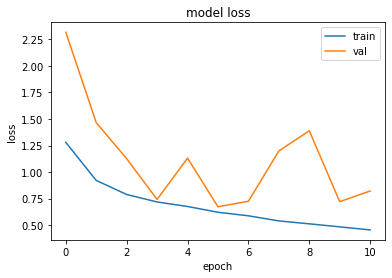

In [17]:
# Plot model loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

print('\nTest accuracy: {:.3f}'.format(test_acc))

94/94 [==============================] - 14s 149ms/step - loss: 0.8216 - accuracy: 0.7253

Test accuracy: 0.725


In [19]:
from keras.utils import img_to_array, load_img
pred_dir = 'intel/seg_pred/seg_pred/'
# load all images into a list

images = []

for img in os.listdir(pred_dir):
    img = os.path.join(pred_dir, img) 
    img = load_img(img, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    images.append(img_array)

# stack up images list to pass for prediction
images = np.vstack(images)
predict = model.predict(images)
score = tf.nn.softmax([predict[0]])
classes = np.argmax(predict, axis=1)

229/229 [==============================] - 34s 148ms/step


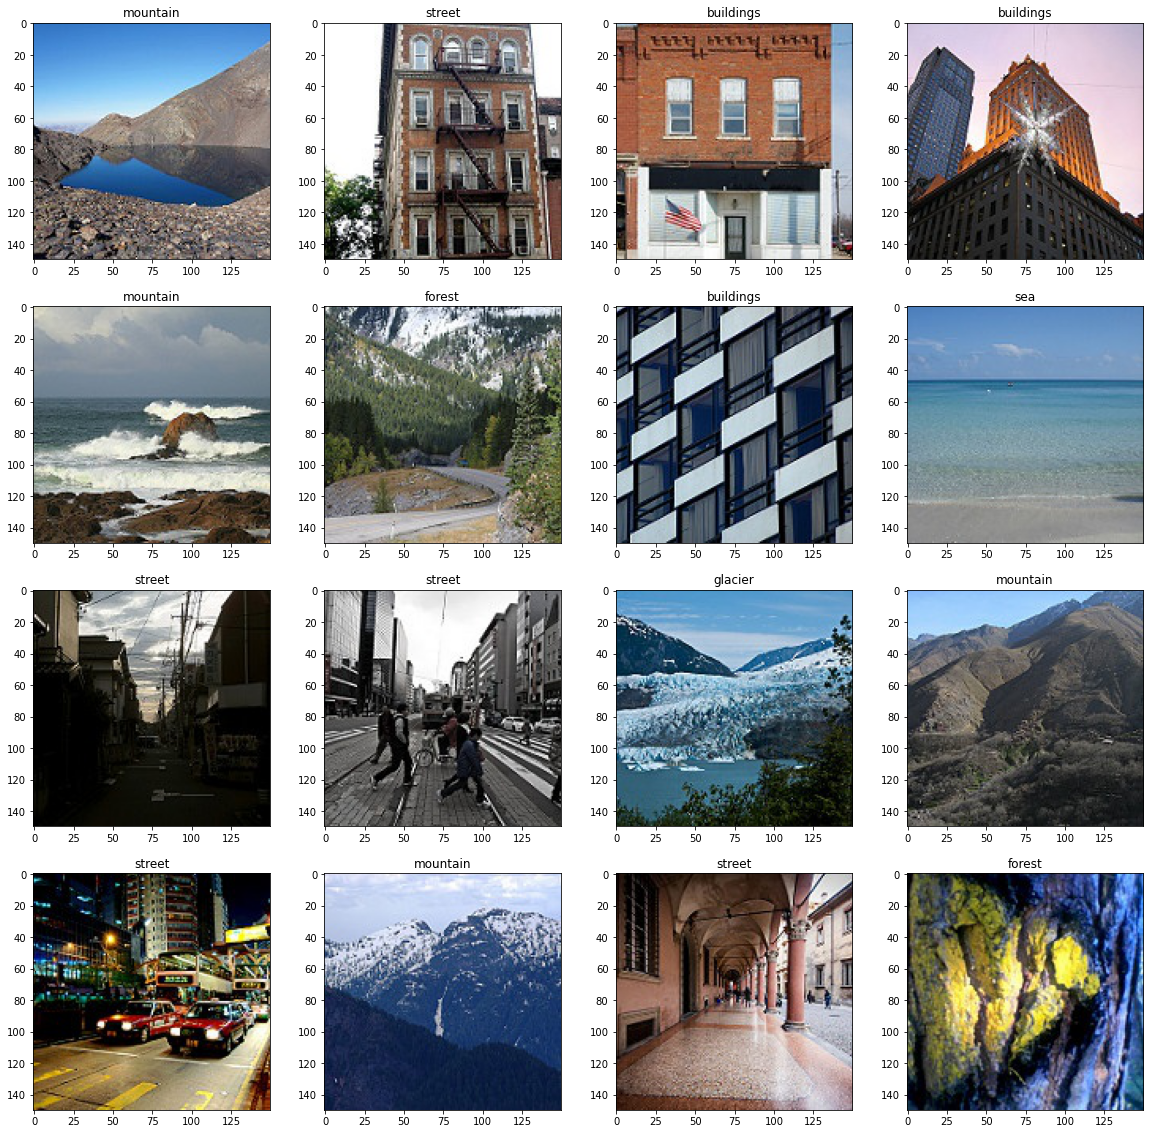

In [20]:
# Plot images 
plt.figure(figsize=(20, 20))

for i in range(16):
    rand = np.random.randint(0,len(images))
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[rand]/255)
    plt.title(class_names[classes[rand]])